This notebook showcases some of the work I did for the Data Science Research Group under Dr. Daisy Wang and Yang (Tony) Bai. This notebook was run on the University of Florida's supercomputer "HiPerGator."

# Config

In [22]:
jobID = "30565323" # change to current slurm id
cache_dir=f"/scratch/local/{jobID}"

# Knowledge Graph Input
I edited a image QA model pipeline to take in knowledge graph inputs from frames of videos in the STAR dataset

## Check installation

In [2]:
import torch
torch.__version__

'2.1.1+cu121'

In [3]:
devices = torch._C._cuda_getDeviceCount()
if torch._C._cuda_getDeviceCount() < 1:
    print("CUDA not working. Should be greater than 1")
print(f"Number of CUDA devices detected: {devices}")

Number of CUDA devices detected: 1


In [4]:
!nvidia-smi

Wed May  1 20:58:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   41C    P0              90W / 400W |  12679MiB / 81920MiB |     43%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Import Libraries and Set-up Pipelines
VQA model: llava-hf/llava-1.5-7b-hf

TQA model: NousResearch/Llama-2-7b-chat-hf

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import absolute_import

import os
import sys

pwd = os.getcwd()
sys.path.append('/'.join(pwd.split('/')[:-3]))
sys.path.append('/'.join(pwd.split('/')[:-2]))
sys.path.append('/'.join(pwd.split('/')[:-1]))

from PIL import Image
import requests
import torch
from typing import List, Optional
import shutil

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging,
)

from utils import read_json, make_directory, save_json
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

In [10]:
def get_textual_chat_pipeline(model_name: str=None,
                              ):
    # Load the entire model on the GPU 0
    device_map = {"": 0}

    # Activate 4-bit precision base model loading
    use_4bit = True

    # Compute dtype for 4-bit base models
    bnb_4bit_compute_dtype = "float16"

    # Quantization type (fp4 or nf4)
    bnb_4bit_quant_type = "nf4"

    # Activate nested quantization for 4-bit base models (double quantization)
    use_nested_quant = False

    # Load tokenizer and model with QLoRA configuration
    compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=use_4bit,
        bnb_4bit_quant_type=bnb_4bit_quant_type,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=use_nested_quant,
    )

    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        # device_map=device_map,
        device_map='auto',
        cache_dir=cache_dir # change to current slurm id
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    
    # Load LLaMA tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training
    
    pipe = pipeline(task="text-generation", 
                    model=model, 
                    tokenizer=tokenizer, 
                    max_length=2000, 
                    )
    return pipe

In [11]:
def get_llava_pipeline(vqa_model_name: str=None,
                     ):
    quantization_config = BitsAndBytesConfig(
                                                load_in_4bit=True,
                                                bnb_4bit_compute_dtype=torch.float16
                                            )
    
    pipe = pipeline("image-to-text", 
                    model=vqa_model_name, 
                    model_kwargs={"quantization_config": quantization_config,
                                  "cache_dir" : cache_dir},
                    device_map='auto',
                   )
    return pipe

In [12]:
def img_qa(txt: str=None,
           img_url: str=None,
           img_path: str=None,
           llava_pipeline=None,
           show_img: bool=False,
           max_new_tokens: int=100,
          ) -> str:
    
    if not os.path.exists(img_path) or img_url != None:
        print(f"Getting image from: {img_url}")
        image = Image.open(requests.get(img_url, stream=True).raw)
    else:
        image = Image.open(img_path)
    
    try:
        if show_img:
            display(image)
    except:
        pass
    
#     prompt = "USER: <image>\nWhat's the content of the image?\nASSISTANT:"
    prompt = f"USER: <image>\n{txt}\nASSISTANT:"
    outputs = llava_pipeline(image, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens})
    return outputs[0]['generated_text'].split('ASSISTANT:')[-1].strip()

In [13]:
def get_prompt_from_image_caption(img_caps: List[str]=None):
    output = 'Answer the question, giving following context:'
    for idx, cap in enumerate(img_caps):
        output += f"\nimage{idx}: {cap} "
    return output

def get_prompt_from_chat_history(chat_history: List[dict]=None) -> str:
    output = 'Please also take following chat history into consideration: '
    for idx, turn in enumerate(chat_history):
        output += f"\nUSER: {turn['question']}  ANSWER: {turn['answer']}"
    return output

In [14]:
def get_img_captions(img_urls: List[str]=None,
                     img_paths: List[str]=None,
                     llava_pipeline=None,
                     txt_list: List[str]=["What is the name of the major object in the image? What's the content of the image?"],
                     show_img: bool=False,
                     max_new_tokens: int=100,
                     database_dir: str=None,
                     device='cpu',
                     ) -> List[str]:
    outputs = []
    img_cache_path_list = []
    if img_urls:
        for img_url in img_urls:
            print(f"Getting image from: {img_url}")
            r = requests.get(img_url, stream=True)
            if r.status_code == 200:
                img_cache_path = os.path.join(database_dir, 'img', img_url.split('/')[-1])
                with open(img_cache_path, 'wb') as f:
                    r.raw.decode_content = True
                    shutil.copyfileobj(r.raw, f)
            else:
                print(f"WARNING: Failed to download image with url provided: {img_url}")
            
            img_cache_path_list.append(img_cache_path)

            answers = ""
            
            for txt in txt_list:
                ans = img_qa(txt=txt,
                            img_path = img_cache_path,
                            llava_pipeline=llava_pipeline,
                            show_img=show_img,
                            max_new_tokens=max_new_tokens,
                            )
                answers += ans
                answers = answers.strip()
                answers.replace('?', '.')
                answers.replace('!', '.')
                if answers[-1] != '.':
                    answers += '.'
                
            outputs.append(', '.join(answers.split('.')).strip(', ') + '.')
    elif img_paths:
        for img_path in img_paths:
            img_cache_path_list.append(img_path)

            answers = ""
            for txt in txt_list:
                ans = img_qa(txt=txt,
                            img_path = img_path,
                            llava_pipeline=llava_pipeline,
                            show_img=show_img,
                            max_new_tokens=max_new_tokens,
                        )
                answers += ans
                answers = answers.strip()
                answers.replace('?', '.')
                answers.replace('!', '.')
                if answers[-1] != '.':
                    answers += '.'
                
            outputs.append(', '.join(answers.split('.')).strip(', ') + '.')
    else:
        print("WARNING: no image is provided.")
        
    return outputs, img_cache_path_list

In [15]:
def process_image_question(question: str=None,
                            llava_pipeline=None,
                            knowledge_graph=None, # enter as a list of kgs
                            use_chat_history=True, # flag to toggle chat history use
                            img_urls: Optional[List[str]]=[],
                            img_paths: Optional[List[str]]=[],
                            img_cap_prompts: List[str]=["What is the name of the main object in the image? Please describe its features."],
                            llama_pipeline = None,
                            max_new_tokens: int = 100,
                            database_dir: str = None,
                            usr_id: str = 'test_usr',
                            ) -> str:
    """
    LLaVa models:
       'llava-hf/llava-1.5-7b-hf'  # 15GB
       'llava-hf/llava-1.5-13b-hf' # 22GB

    LLaMa2 models:
        'NousResearch/Llama-2-7b-chat-hf'  # 13.5GB
        'NousResearch/Llama-2-13b-chat-hf' # 26GB
        'NousResearch/Llama-2-70b-chat-hf' # 140.5GB
    """
    print(f"question: {question}")
    print(f"img_urls: {img_urls}")
    print(f"img_paths: {img_paths}")
    print(f"img_cap_prompts: {img_cap_prompts}")
    print(f"database_dir: {database_dir}")
    print(f"usr_id: {usr_id}")

    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu")
    print(f"device {device} ")

    if database_dir and not os.path.exists(database_dir):
        make_directory(database_dir)
    if not os.path.exists(os.path.join(database_dir, 'img')):
        make_directory(os.path.join(database_dir, 'img'))

    all_usr_cache_path = os.path.join(database_dir, 'all_users.json')
    if os.path.exists(all_usr_cache_path):
        all_users = read_json(all_usr_cache_path)
        if usr_id not in all_users:
            all_users[usr_id] = []
            chat_history = None
        else:
            chat_history = all_users[usr_id]
    else:
        all_users = {usr_id: []}
        chat_history = None 
        
    """
    adding knowledge graphs as a input
    """
    kg_input = False
    if knowledge_graph:
        prompt = 'Answer the question, using the following knowledge graph as context. Each relationship pair in connected by its corresponding relationship label.\n'
        # multiple kg inputs
        if len(knowledge_graph) > 1:
            for idx, kg in enumerate(knowledge_graph):
                prompt += f"\nKnowledge Graph{idx}: {str(kg)} "
        else:
            # assume valid KG as input
            str_kg = str(knowledge_graph[0])
            prompt = "Knowledge Graph: " + str_kg
        kg_input = True
    
    elif img_urls or img_paths:
        # multiple images
        if len(img_urls) > 1 or len(img_paths) > 1:
            img_captions, img_cache_path_list = get_img_captions(img_urls=img_urls,
                                                                img_paths=img_paths,
                                                                llava_pipeline=llava_pipeline,
                                                                show_img=True,
                                                                txt_list=img_cap_prompts,
                                                                max_new_tokens=max_new_tokens,
                                                                database_dir=database_dir,
                                                            )
            prompt = get_prompt_from_image_caption(img_caps=img_captions)
        else:
            img_captions, img_cache_path_list =  get_img_captions(img_urls=img_urls,
                                                                    img_paths=img_paths,
                                                                    llava_pipeline=llava_pipeline,
                                                                    show_img=True,
                                                                    txt_list=[question],
                                                                    max_new_tokens=max_new_tokens,
                                                                    database_dir=database_dir,
                                                                )
            
            all_users[usr_id].append({'question': question, 'img_path_list': img_cache_path_list, 'answer': img_captions[0]})
            save_json(all_users, all_usr_cache_path)
            return img_captions[0]
    else:
        prompt = ""
        img_cache_path_list = []
        
    if use_chat_history:
        chat_history_prompt = get_prompt_from_chat_history(chat_history) if chat_history else ''
        print(f"chat_history_prompt: {chat_history_prompt}")
        prompt += chat_history_prompt
        
    print(f"llama prompt: {prompt}")

    result = llama_pipeline(f"<s>[INST] <<SYS>> please generate answer according to following context: {prompt} <</SYS>> {question} [/INST]")
    answer = result[0]['generated_text'].split('[/INST]')[-1].strip()
    # add kg to json file for user
    if kg_input:
        all_users[usr_id].append({'question': question, 'knowledge_graphs': knowledge_graph, 'answer': answer})
        save_json(all_users, all_usr_cache_path)
    # add image path to json file for user
    else:
        all_users[usr_id].append({'question': question, 'img_path_list': img_cache_path_list, 'answer': answer})
        save_json(all_users, all_usr_cache_path)
        
    return answer

In [16]:
import os
os.environ['HF_DATASETS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir

In [17]:
vqa_model_name ='llava-hf/llava-1.5-7b-hf'
tqa_model_name = "NousResearch/Llama-2-7b-chat-hf"

# vqa_model_name = "llava-hf/llava-1.5-13b-hf"
# tqa_model_name = 'NousResearch/Llama-2-70b-chat-hf'

llava_pipeline = get_llava_pipeline(vqa_model_name = vqa_model_name)
llama_pipeline = get_textual_chat_pipeline(model_name=tqa_model_name)

/home/smaley/.local/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/smaley/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/smaley/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/smaley/.local/lib/python3.10/site-packages/transform

In [18]:
database_dir='./database'
img_cap_prompts =["What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc."]
img_cap_prompts

['What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc.']

## Demoing functionality
Test the model on images from the STAR dataset

In [20]:
usr_id=f'usr_chat_113' # where to save chat history

### Test accuracy when using the image itself as input

question: What is the man holding?
img_urls: []
img_paths: ['../KG_Generation/images/024PD_001583.png']
img_cap_prompts: ['What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc.']
database_dir: ./database
usr_id: usr_chat_113
device cuda 


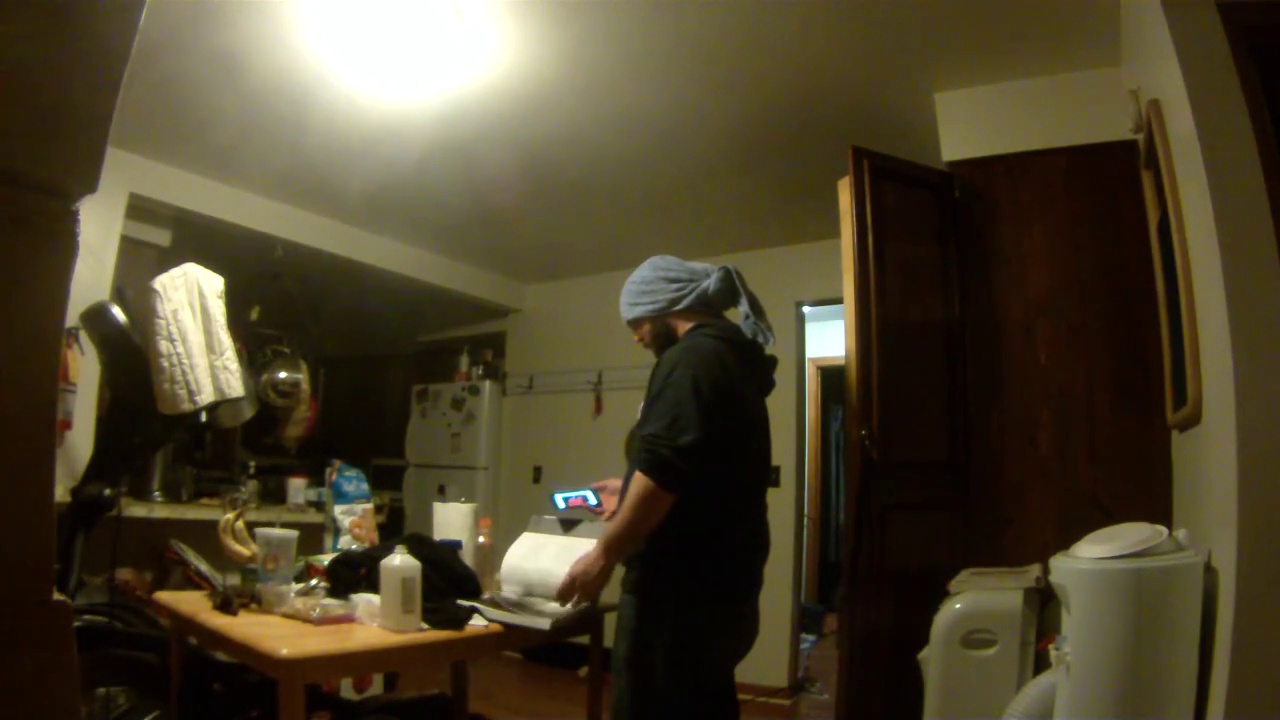

In [27]:
question = 'What is the man holding?' # expected: cell phone

img_paths = ['../KG_Generation/images/024PD_001583.png'] # pass image into model

output = process_image_question(question=question,
                                llava_pipeline=llava_pipeline,
                                use_chat_history=False, # disable chat history in creating response
                                img_paths=img_paths,
                                img_cap_prompts=img_cap_prompts,
                                llama_pipeline=llama_pipeline,
                                database_dir=database_dir,
                                usr_id=usr_id,
                                )

In [29]:
print(output) # the model provides an accurate response

The man is holding a cell phone.


### Test using KG as input

In [47]:
question = 'What is the man holding?' # expected: cell phone

kg1 = {'rel_pairs': [['person', 'book'], ['person', 'phone/camera'], ['person', 'phone/camera']],'rel_labels': ['touching', 'in_front_of', 'holding'],'actions': ['close a book','make a call']}

kg_input = [kg1]

output = process_image_question(question=question,
                                # llava_pipeline=llava_pipeline,
                                knowledge_graph=kg_input,
                                use_chat_history=False,
                                img_cap_prompts=img_cap_prompts,
                                llama_pipeline=llama_pipeline,
                                database_dir=database_dir,
                                usr_id=usr_id,
                                )

question: What is the man holding?
img_urls: []
img_paths: []
img_cap_prompts: ['What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc.']
database_dir: ./database
usr_id: usr_chat_113
device cuda 
llama prompt: Knowledge Graph: {'rel_pairs': [['person', 'book'], ['person', 'phone/camera'], ['person', 'phone/camera']], 'rel_labels': ['touching', 'in_front_of', 'holding'], 'actions': ['close a book', 'make a call']}


In [48]:
print(output) # the model provides an accurate response

Based on the information provided in the Knowledge Graph, the man is holding a phone or a camera. nobody.


It is worth noting that the quality of the response depends entirely on the quality of the inputted knowledge graph.

### Testing multiple KGs/images

question: What is the difference in the object being held in the two images?
img_urls: []
img_paths: ['../KG_Generation/images/3B97C_000363.png', '../KG_Generation/images/9LHP3_000532.png']
img_cap_prompts: ['What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc.']
database_dir: ./database
usr_id: usr_chat_113
device cuda 


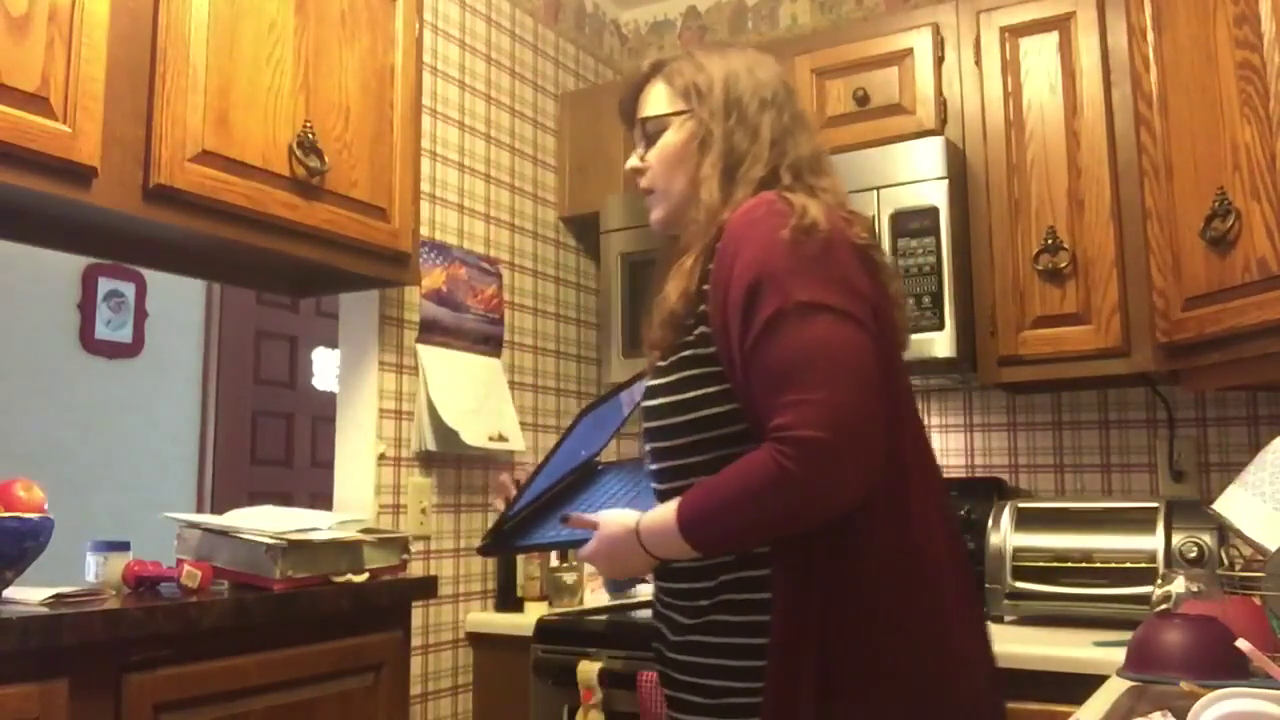

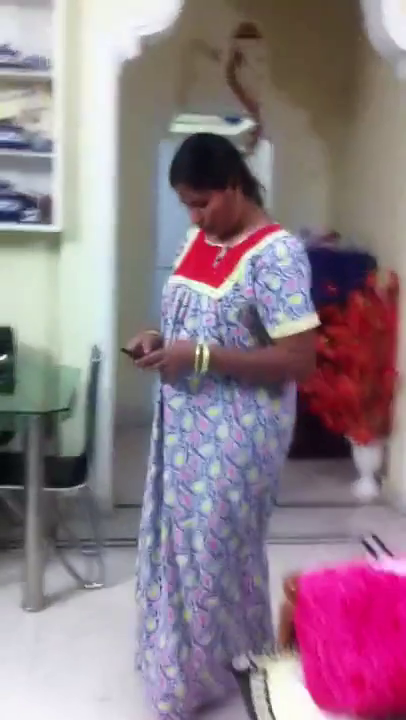

llama prompt: Answer the question, giving following context:
image0: The main object in the image is a laptop computer,  It is placed on a counter, and the woman is holding it,  The laptop is black and white in color, and it appears to be a functional device for work or entertainment purposes,  The woman is standing next to the laptop, possibly preparing to use it or showcasing its features. 
image1: The main object in the image is a woman wearing a colorful dress,  She is standing in a room and looking at her cell phone,  The room appears to be a living room, as there is a dining table and a chair in the background,  The woman's dress is multicolored, which adds a vibrant and lively touch to the scene. 


In [59]:
question = "What is the difference in the object being held in the two images?" # Expected: holding laptop vs cell phone

img_paths = ['../KG_Generation/images/3B97C_000363.png','../KG_Generation/images/9LHP3_000532.png']

output = process_image_question(question=question,
                                llava_pipeline=llava_pipeline,
                                img_paths=img_paths,
                                use_chat_history=False,
                                img_cap_prompts=img_cap_prompts,
                                llama_pipeline=llama_pipeline,
                                database_dir=database_dir,
                                usr_id=usr_id,
                                )

In [60]:
print(output)

In the two images, the main object being held differs significantly.

In image0, the main object being held is a laptop computer. The laptop is a functional device for work or entertainment purposes, and it is placed on a counter. The woman is standing next to the laptop, possibly preparing to use it or showcasing its features.

In image1, the main object being held is a cell phone. The woman is standing in a room and looking at her cell phone, which is a small, portable device used for communication and entertainment purposes. The room appears to be a living room, with a dining table and a chair in the background, which suggests that the woman is in a comfortable and familiar environment.

Overall, the main object being held in the two images is quite different. In image0, the object is a larger, more complex device, while in image1, the object is a smaller, more portable device. Additionally, the context and setting of the two images are different, with image0 depicting a more profes

Using the images as input provides and accurate and detailed response

In [61]:
# build knowledge graphs based on corresponding images
kg2 = {'rel_pairs': [['person', 'table'], ['person', 'shelf'], ['person', 'laptop'], ['person', 'laptop']], 'rel_labels': ['in_front_of', 'in_front_of', 'holding', 'in_front_of'], 'actions': ['put a laptop somewhere']}

kg3 = {'rel_pairs': [['person', 'phone/camera'], ['person', 'phone/camera'], ['person', 'sofa/couch'], ['o000', 'sofa/couch']], 'rel_labels': ['holding', 'in_front_of', 'on_the_side_of', 'beneath'], 'actions': ['hold a phone/camera']}

In [62]:
question = "What is the difference in the object being held in the two images?" # Expected: holding laptop vs cell phone

kg_input = [kg2,kg3]

output = process_image_question(question=question,
                                llava_pipeline=llava_pipeline,
                                knowledge_graph=kg_input,
                                use_chat_history=False,
                                img_cap_prompts=img_cap_prompts,
                                llama_pipeline=llama_pipeline,
                                database_dir=database_dir,
                                usr_id=usr_id,
                                )

question: What is the difference in the object being held in the two images?
img_urls: []
img_paths: []
img_cap_prompts: ['What is the name of the main object in the image? Please describe its features from aspects of color, shape, position, functionality, etc.']
database_dir: ./database
usr_id: usr_chat_113
device cuda 
llama prompt: Answer the question, using the following knowledge graph as context. Each relationship pair in connected by its corresponding relationship label.

Knowledge Graph0: {'rel_pairs': [['person', 'table'], ['person', 'shelf'], ['person', 'laptop'], ['person', 'laptop']], 'rel_labels': ['in_front_of', 'in_front_of', 'holding', 'in_front_of'], 'actions': ['put a laptop somewhere']} 
Knowledge Graph1: {'rel_pairs': [['person', 'phone/camera'], ['person', 'phone/camera'], ['person', 'sofa/couch'], ['o000', 'sofa/couch']], 'rel_labels': ['holding', 'in_front_of', 'on_the_side_of', 'beneath'], 'actions': ['hold a phone/camera']} 


In [63]:
print(output)

Based on the knowledge graphs provided, the difference in the object being held in the two images is:

In the first image, the person is holding a laptop.

In the second image, the person is holding a phone/camera.

Therefore, the difference is that the object being held in the second image is a phone/camera, whereas in the first image it is a laptop.


The model successfully locates the difference in the KGs

# Image Captioning with Segment Anything
I implemented a image captioning model using Meta's Segment Anything and Salesforce's Blip Image Captioning model.

## Install models

In [5]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/huggingface/transformers.git to /scratch/local/30565323/pip-req-build-9dyyewun
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /scratch/local/30565323/pip-req-build-9dyyewun
  Resolved https://github.com/huggingface/transformers.git to commit c681b58b06f6fb8b5c331f380548af3b4b33f881
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9037771 sha256=f4c58dd91a0bc954e1efff3def94d0b1098451a91e69a63ef296574c70049eb4
  Stored in directory: /scratch/local/30565323/pip-ephem-wheel-cache-enwjhry1/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea927427

## Load image from video

In [2]:
vid_id = "crawl7" # enter video id, exlude extension (.mp4 etc)
frame = 10

In [3]:
import os

path = "/blue/daisyw/smaley/ecole/fromTony/jupyternotebooks/captioning_demo/DARPA_vids/" + vid_id + ".mp4"
cmd = f"ffmpeg -i {path} -vf \"select=eq(n\,{frame})\" -vframes 1 /blue/daisyw/smaley/ecole/fromTony/jupyternotebooks/captioning_demo/generated_imgs/{vid_id}_{frame}.png"
os.system(cmd)

sh: ffmpeg: command not found


32512

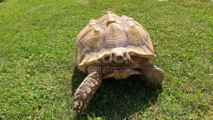

In [12]:
import requests
from PIL import Image

img_path = f'/blue/daisyw/smaley/ecole/fromTony/jupyternotebooks/captioning_demo/generated_imgs/{vid_id}_{frame}.png'
image = Image.open(img_path)

width, height = image.size
display(image.resize(((width // 3, height // 3))))

## Segementer Testing

In [8]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-05-01 22:43:46--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.48, 18.173.166.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   159MB/s    in 16s     

2024-05-01 22:44:02 (151 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [9]:
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=checkpoint)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [13]:
import cv2
import numpy as np

mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

In [14]:
box = np.array([190, 31, 500, 340])
# w, h = box[2] - box[0], box[3] - box[1]
# x0, y0 = box[0], box[1]

We manually provide the input for the bounding box here

In [15]:
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


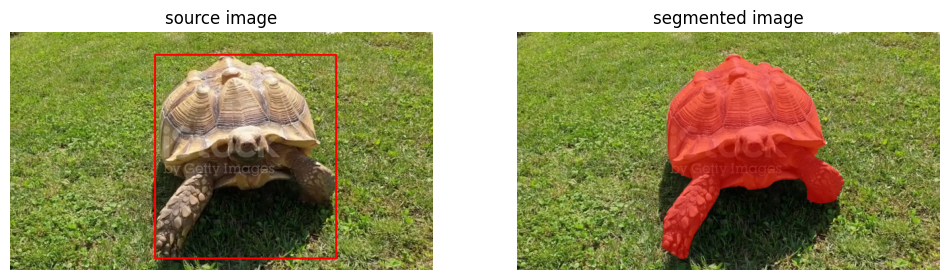

In [16]:
import supervision as sv

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

Segment Anything provides the input mask for Blip

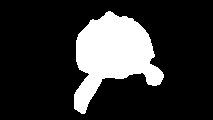

In [17]:
masks = masks[0, ...]
display(Image.fromarray(masks).resize(((width // 3, height // 3))))

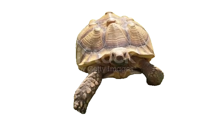

In [18]:
crop_mode = "wo_bg" 

if crop_mode == "wo_bg":
    masked_image = image * masks[:,:,np.newaxis] + (1 - masks[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width // 3, height // 3)))

0.34375 0.053125 0.76875 0.5328125


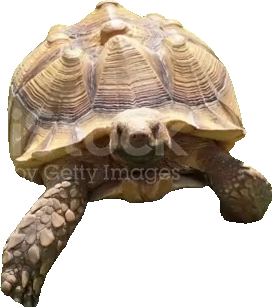

In [19]:
def boundary(inputs):

    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col

    return top, bottom

def seg_to_box(seg_mask, size):

    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

size = max(masks.shape[0], masks.shape[1])
left, top, right, bottom = seg_to_box(masks, size) # calculating the position of the top-left and bottom-right corners in the image
print(left, top, right, bottom)

image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
display(image_crop)

In [21]:
crop_file_path = f"{vid_id}_{frame}_cropped.png"
image_crop.save(crop_file_path)

## Load captioning model

In [23]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# https://huggingface.co/Salesforce/blip-image-captioning-large
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", cache_dir=cache_dir)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", cache_dir=cache_dir).to("cuda")

raw_image = Image.open(crop_file_path).convert('RGB')

2024-05-01 22:47:24.054401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 22:47:24.054466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 22:47:24.055359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 22:47:24.060751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 22:47:26.546866: W tensorflow/compiler/tf2

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [24]:
inputs = processor(raw_image, return_tensors="pt").to("cuda")
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a close up of a turtle with a white background


Here we receive accurate output from Blip